In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        #Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=1),  #Input (28, 28, 1) > Output (28, 28, 8)
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1),  #Input (28, 28, 8) > Output (28, 28, 8) 
            nn.ReLU()
        )

        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2,2),  #Input (28, 28, 8) > Output (14, 14, 8)

            nn.Conv2d(8, 16, 3, padding=1),  #Input (14, 14, 8) > Output (14, 14, 16)
            nn.ReLU(),

            nn.Conv2d(16, 8, 3, padding=1),  #Input (14, 14, 16) > Output (14, 14, 8)
            nn.ReLU()
        )

        self.trans2 = nn.Sequential(
            nn.MaxPool2d(2,2),  #Input (14, 14, 1) > Output (7, 7, 8)

            nn.Conv2d(8, 16, 3),  #Input (7, 7, 8) > Output (5, 5, 16)
            nn.ReLU(),

            nn.Conv2d(16, 16, 3),  #Input (5, 5, 16) > Output (3, 3, 16)
            nn.ReLU(),

            nn.Conv2d(16, 10, 3),  #Input (3, 3, 16) > Output (1, 1, 10)
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.trans2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             584
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,168
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8            [-1, 8, 14, 14]           1,160
              ReLU-9            [-1, 8, 14, 14]               0
        MaxPool2d-10              [-1, 8, 7, 7]               0
           Conv2d-11             [-1, 16, 5, 5]           1,168
             ReLU-12             [-1, 16, 5, 5]               0
    

<ipython-input-2-27bb351bbd7a>:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [4]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128])


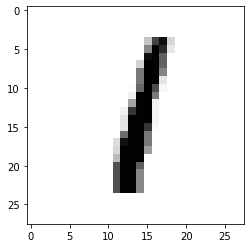

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[5].numpy().squeeze(), cmap='gray_r')

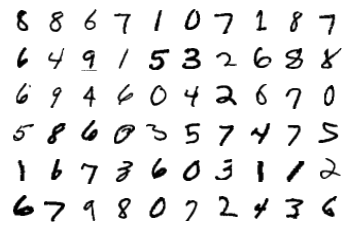

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [9]:
from tqdm import tqdm

train_losses = []
train_accs = []
test_losses = []
test_accs= []

def train(model, device, train_loader, optimizer, epoch):
    correct_preds = 0
    processed = 0
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # Porting the data and targets in to the GPU
        data, target = data.to(device), target.to(device)

        # setting all the gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Loss calculation 
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Back propogation
        loss.backward()

        # Updating the weights with calculated gradients
        optimizer.step()

        # Calculating the correct number of predictions
        preds = output.argmax(dim=1, keepdim=True)
        correct_preds += preds.eq(target.view_as(preds)).sum().item()
        processed += len(data)
        
        # Logging the results using Pbar
        pbar.set_description(desc= f'Epoch={epoch} Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct_preds/processed:0.2f}')

        # Appending the training accuracies to the train_accs[]
        train_accs.append(100*correct_preds/processed)
        


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Porting the data and targets in to the GPU
            data, target = data.to(device), target.to(device)

            # Predict 
            output = model(data)

            # Test loss calculation
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_accs.append(100. * correct / len(test_loader.dataset))

In [10]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs = 15
for epoch in range(0, num_epochs):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]<ipython-input-2-27bb351bbd7a>:69: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
Epoch=0 Loss=2.301236391067505 Batch_id=468 Accuracy=10.43: 100%|██████████| 469/469 [00:13<00:00, 34.67it/s]



Test set: Average loss: 2.3007, Accuracy: 1713/10000 (17.13%)



Epoch=1 Loss=0.6346316933631897 Batch_id=468 Accuracy=46.43: 100%|██████████| 469/469 [00:13<00:00, 35.44it/s]



Test set: Average loss: 0.6352, Accuracy: 7468/10000 (74.68%)



Epoch=2 Loss=0.6198306679725647 Batch_id=468 Accuracy=75.63: 100%|██████████| 469/469 [00:13<00:00, 35.24it/s]



Test set: Average loss: 0.5651, Accuracy: 7653/10000 (76.53%)



Epoch=3 Loss=0.12826406955718994 Batch_id=468 Accuracy=86.15: 100%|██████████| 469/469 [00:13<00:00, 35.11it/s]



Test set: Average loss: 0.3026, Accuracy: 8792/10000 (87.92%)



Epoch=4 Loss=0.3035184442996979 Batch_id=468 Accuracy=87.96: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]



Test set: Average loss: 0.2850, Accuracy: 8828/10000 (88.28%)



Epoch=5 Loss=0.1282820701599121 Batch_id=468 Accuracy=88.24: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]



Test set: Average loss: 0.2924, Accuracy: 8824/10000 (88.24%)



Epoch=6 Loss=0.1980672925710678 Batch_id=468 Accuracy=88.41: 100%|██████████| 469/469 [00:13<00:00, 35.85it/s]



Test set: Average loss: 0.2811, Accuracy: 8831/10000 (88.31%)



Epoch=7 Loss=0.035645198076963425 Batch_id=468 Accuracy=89.50: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]



Test set: Average loss: 0.0473, Accuracy: 9839/10000 (98.39%)



Epoch=8 Loss=0.022978544235229492 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]



Test set: Average loss: 0.0400, Accuracy: 9873/10000 (98.73%)



Epoch=9 Loss=0.023139474913477898 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.82it/s]



Test set: Average loss: 0.0359, Accuracy: 9890/10000 (98.90%)



Epoch=10 Loss=0.034112632274627686 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.70it/s]



Test set: Average loss: 0.0294, Accuracy: 9894/10000 (98.94%)



Epoch=11 Loss=0.06187636777758598 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]



Test set: Average loss: 0.0412, Accuracy: 9864/10000 (98.64%)



Epoch=12 Loss=0.035427529364824295 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.65it/s]



Test set: Average loss: 0.0338, Accuracy: 9893/10000 (98.93%)



Epoch=13 Loss=0.06789065897464752 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 35.03it/s]



Test set: Average loss: 0.0397, Accuracy: 9866/10000 (98.66%)



Epoch=14 Loss=0.004326194059103727 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:13<00:00, 35.54it/s]



Test set: Average loss: 0.0319, Accuracy: 9891/10000 (98.91%)



In [11]:
import numpy 
train_losses = [i.cpu().detach().numpy() for i in train_losses]

In [12]:
test_losses = [i for i in test_losses]
train_accs = [i for i in train_accs]
test_accs = [i for i in test_accs]

Text(0.5, 1.0, 'Test Accuracy')

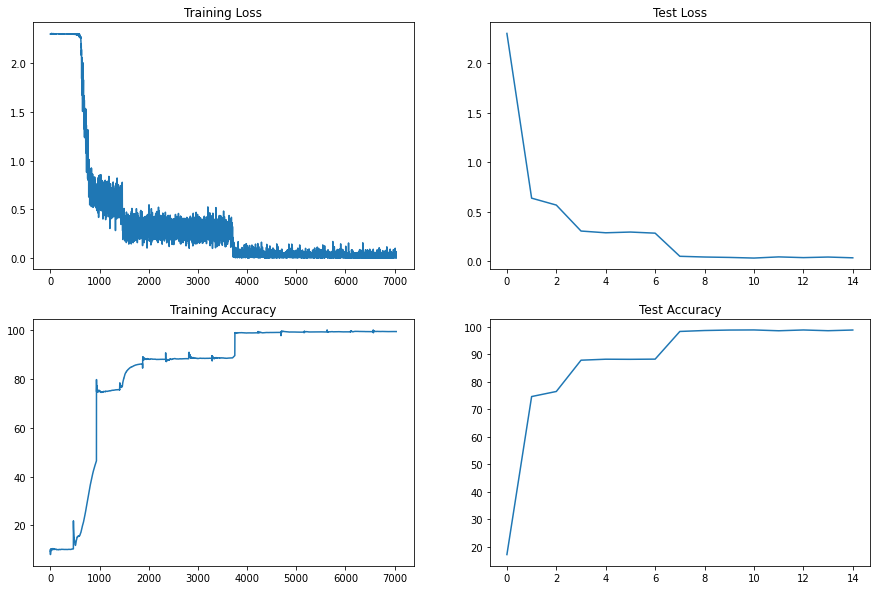

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accs)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accs)
axs[1, 1].set_title("Test Accuracy")